# "Image scraping DuckDuckGo and Google"
> "Image scraper notebook for creating DL datasets"

- toc: true
- badges: true
- comments: true
- categories: [DL,Projects]

In [ ]:
#hide
from IPython.display import Image as IPImage

def url_image(url):
  display(IPImage(url=url))

def local_image(fn):
  display(IPImage(filename=fn))

I’ve written a notebook for scraping images from DuckDuckGo and Google for the purpose of creating DL datasets.



You download images by labels like so:

In [ ]:
ZIP_NAME = "pets.zip"

duckduckgo_search("Dogs", "dogs puppies", max_results=20)
duckduckgo_search("Cats", "cats kittens", max_results=20)
duckduckgo_search("Birds", "parrots budgies cockatoos", max_results=20)

You can constrain DDG searches as follows:

```
duckduckgo_search(label: str, keywords: str, max_results: int=100,
                      img_size: ImgSize=ImgSize.Thumbs, 
                      img_type: ImgType=ImgType.Photo,
                      img_layout: ImgLayout=ImgLayout.Square,
                      img_color: ImgColor=ImgColor.All) -> None:

img_size can be one of the following: (default=ImgSize.Thumbs)
Thumbs, Small, Medium, Large, Wallpaper
 
img_type can be one of the following: (default=ImgType.Photo)
All, Photo, Clipart, Gif, Transparent

img_layout can be one of the following: (default=ImgLayout.Square)
All, Square, Tall, Wide
  
img_color can be one of the following: (default = ImgColor.All)
All, Color, Monochrome, Red, Orange, Yellow, Green, Blue, Purple, Pink, Brown, Black, Gray, Teal, White
```

Then you can run an image cleaner inside the notebook to get rid of anything which doesn't belong.

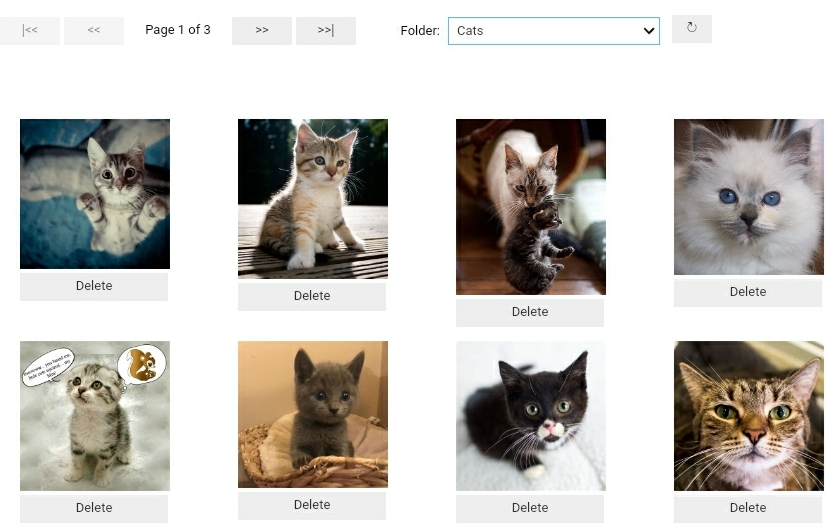

In [ ]:
#hide_input
local_image("scr_clean.jpg")

After that you zip it all up, an either download it or transfer it to your Google Drive.

You can also distribute CSV files with URL/label pairs if you want a massive dataset and a small distributable, and have people download the images themselves.

You can find it here: [github.com/joedockrill/image-scraper](https://github.com/joedockrill/image-scraper)